# Exponential decay of Errors in noisy Trotter circuit

In [1]:
import numpy as np
from evolution import Evolve_ob, Evolve_state
from qiskit.quantum_info import SparsePauliOp, Statevector

from quantum_simulation_recipe.trotter import pf, expH
from quantum_simulation_recipe.plot_config import *
from quantum_simulation_recipe.bounds import tight_bound
from quantum_simulation_recipe.spin import Nearest_Neighbour_1d
# from observable_decay import Evolve_ob, Evolve_state

good_color_cycle = ['#9467bdFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#ff7f0eFF', '#8c564bFF', '#e377c2FF', '#7f7f7fFF', '#bcbd22FF', '#17becfFF']
set_color_cycle(good_color_cycle)

mpl.rcParams['legend.frameon'] = False
# mpl.rcParams['font.family'] = 'sans-serif' # 'Helvetica' 'sans-serif'  
fig_dir, data_dir = './figs', './data'

Matplotlib is building the font cache; this may take a moment.


## Fixed noise rate

In [5]:
H_model = 'nnh'  # Hamiltonian model
p_pf = 2  # Trotter formula order
n = 8 # system size could be 4, 6, 8, 10, 12 ...
gamma = 5e-3  # noise rate
t, r = n, 100
# t, r = 2*n, 100
dt = t/r
t_list = np.arange(0, r)  * dt

## set Hamiltonian parameters
if H_model == 'nnh':
    J, h, pbc = 2, 1, True
    H_model_par = {'Jz': J, 'hx': h, 'pbc': pbc, 'group': 'xyz'}
    nnh = Nearest_Neighbour_1d(n, Jz=J, hx=h, pbc=pbc)
    # H_list = [term.to_matrix() for term in nnh.ham_par]
    H_list = [term.to_matrix() for term in nnh.ham_xyz]

## exact and trotter (approximate) evolution
U_dt_appro = pf(H_list, dt, 1, order=p_pf)
U_dt_exact = expH(sum(H_list), dt)

## the initial state
state_0 = Statevector.from_label('0'*n).to_operator().to_matrix()

In [21]:
## simulate the evolution in noisy Trotter circuit
n_pf = Evolve_state(U_dt_appro, U_dt_exact, r, state_0, gamma, p_pf, t)

100%|██████████| 100/100 [00:30<00:00,  3.29it/s]


c1=334.48011900835246, c2=167.2400595041763


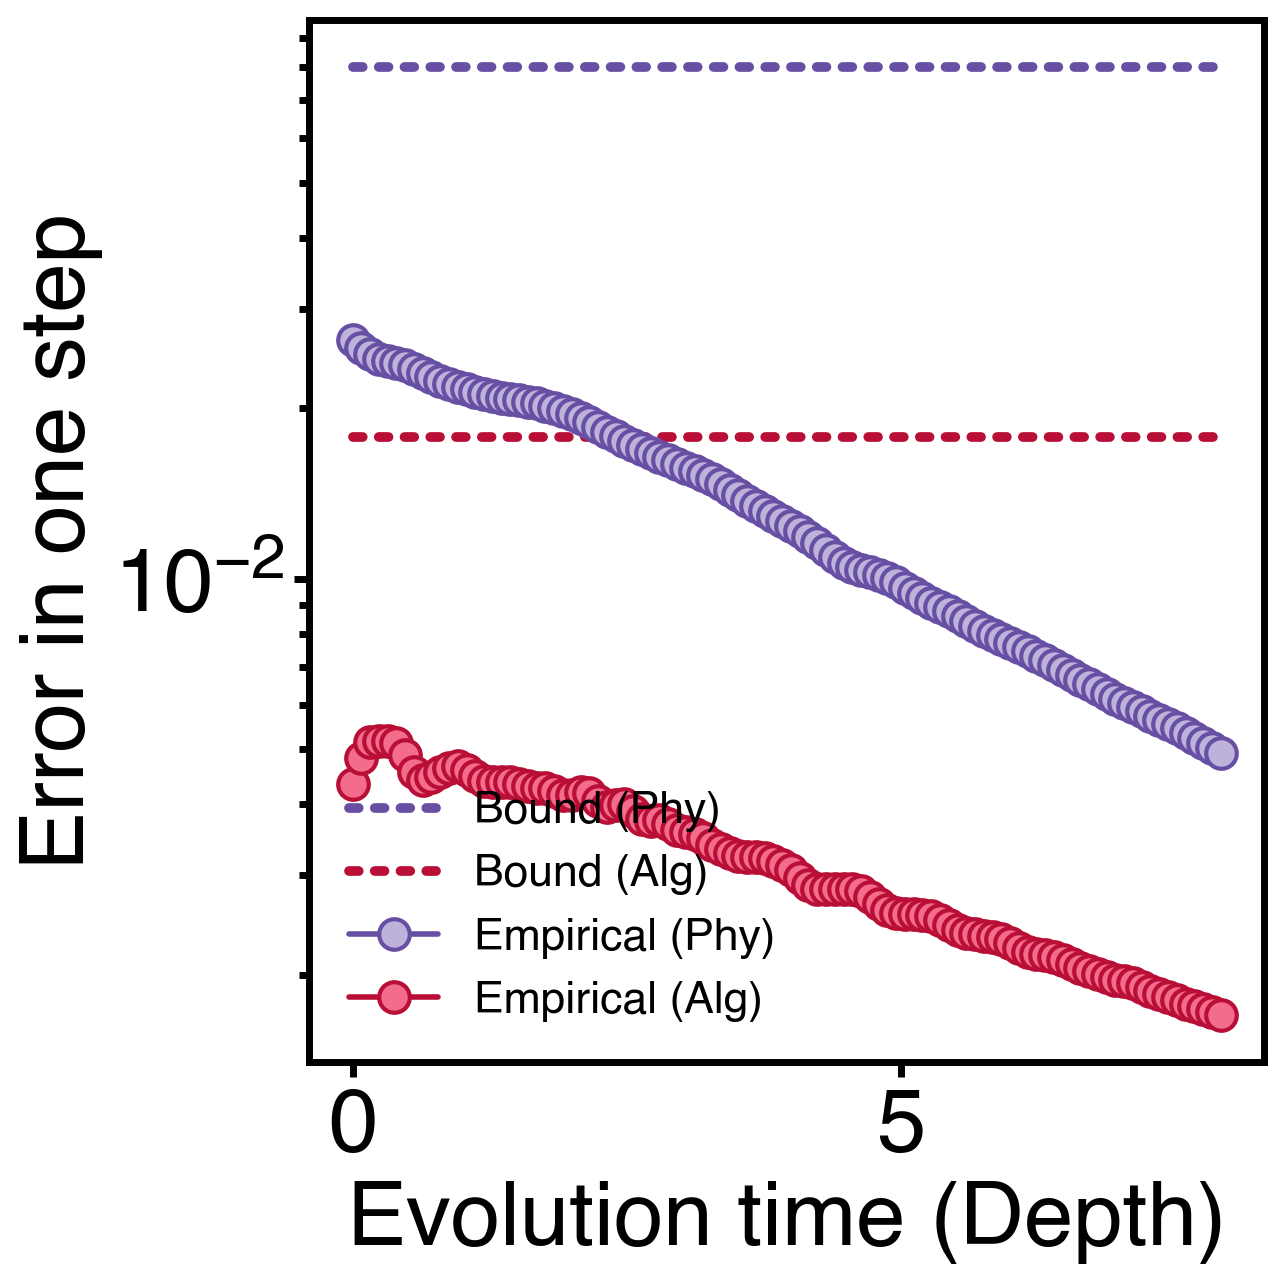

In [23]:
t_list = np.arange(0, r) * dt
set_fontsize(medium=MEDIUM_SIZE+8, large=LARGE_SIZE+8, linewidth=2.5)
plt.rc('legend', fontsize=MEDIUM_SIZE-2) 
gc = GradColors(10)
cm_phy, cm_alg, cm_tot = gc.purple, gc.red, gc.green
gd_idx = 7
phy_plot_color, alg_plot_color, tot_plot_color = cm_phy(gd_idx), cm_alg(gd_idx), cm_tot(gd_idx)
lw_wide = 3.5

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
line1, = plot_evo(ax, t_list, [2*n*gamma]*r, ':', label=f'Bound (Phy)', c=phy_plot_color, lw=lw_wide, return_line=True)
# plot naive alg bnd
naive_alg_bnd = tight_bound(H_list, p_pf, t/r, 1,  verbose=True)
line2, = plot_evo(ax, t_list, [naive_alg_bnd]*r, ':', label=f'Bound (Alg)', c=alg_plot_color, lw=lw_wide, return_line=True)
line3, = plot_evo(ax, t_list, n_pf.phy_err_list, 'o-', label=f'Empirical (Phy)', c=phy_plot_color, lw=2, return_line=True)

line4, = plot_evo(ax, t_list, n_pf.alg_err_list, 'o-', label=f'Empirical (Alg)', c=alg_plot_color, lw=2, return_line=True)

ax_set_text(ax, r'Evolution time $t$ (Depth)', 'Error in one step', log='y')
ax.set_xlabel(r'Evolution time (Depth)', fontweight='bold')
ax.set_ylabel(r'Error in one step', fontweight='bold')

# Create another legend for the second line.
# first_legend = ax.legend(handles=[line1, line3], bbox_to_anchor=(0.30, 0.8), fontsize=22)
# ax.add_artist(first_legend)
# ax.legend(handles=[line2, line4], bbox_to_anchor=(0.30, 0.4), fontsize=22)
ax.legend()
fig.savefig(f'{fig_dir}/illustrate_exp_decay_{H_model}_n={n}_r={r}_gamma={gamma}.pdf', bbox_inches='tight')

## Vary noise rates

In [6]:
## noise range
gamma_num = 6
gamma_min, gamma_max = 0.003, 0.008
gamma_list = np.linspace(gamma_min, gamma_max, num=gamma_num)

In [ ]:
# initialize a dictionary to store the results
phy_errs, alg_errs = {}, {}

# simulate noisy Trotter with different noise rates
for i, gamma in enumerate(gamma_list):
    print(f'noise rate: {gamma:.4f}')
    # n_pf = Evolve_state(U_dt, U_dt_exact, r, state_0, True, p)
    # n_pf = Evolve_state(U_dt, U_dt_exact, r, state_0, p, dt**3)
    n_pf = Evolve_state(U_dt_appro, U_dt_exact, r, state_0, gamma, p_pf, t)
    # store the results in the dictionary
    # data[p] = n_pf
    phy_errs[gamma], alg_errs[gamma] = n_pf.phy_err_list, n_pf.alg_err_list

data = {'phy': phy_errs, 'alg': alg_errs, 'model_par': H_model_par}
np.save(f'{data_dir}/{H_model}_depo_decay_n={n}_t={t}_r={r}_gamma={gamma_min}-{gamma_max}.npy', data)

noise rate: 0.0030
noise rate: 0.0040
noise rate: 0.0050
noise rate: 0.0060
noise rate: 0.0070
noise rate: 0.0080


c1=334.48011900835246, c2=167.2400595041763


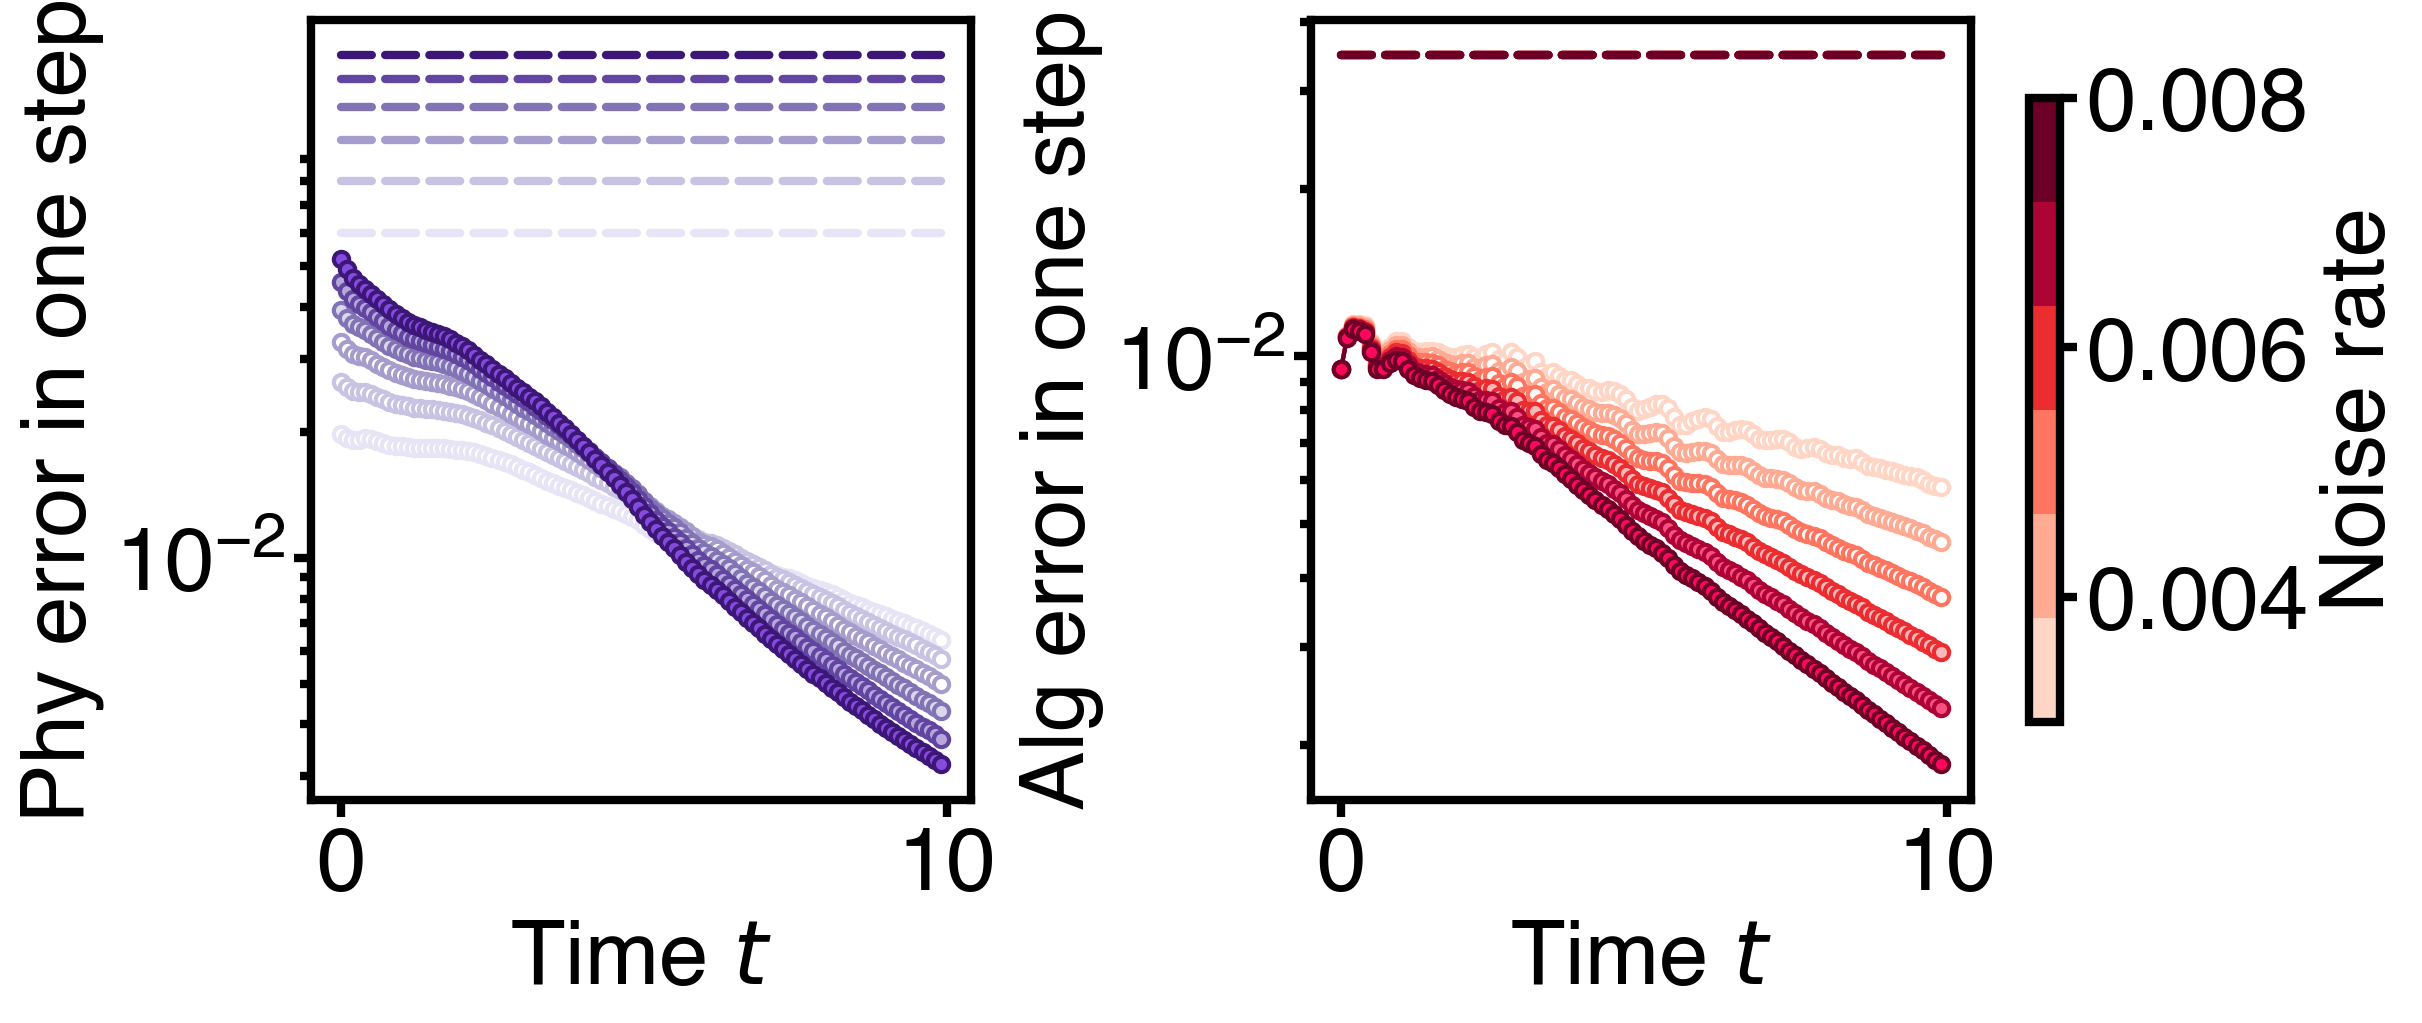

In [9]:
# read the data from the numpy file
H_model = 'nnh'

n = 10
# n = 8
gamma = 5e-3
t, r = n, 100
dt = t/r
t_list = np.arange(0, r)  * dt

data = np.load(f'{data_dir}/{H_model}_depo_decay_n={n}_t={t}_r={r}_gamma={gamma_min}-{gamma_max}.npy', allow_pickle=True).item()

set_fontsize(medium=MEDIUM_SIZE+8, large=LARGE_SIZE+8, linewidth=3.0)
gc = GradColors(gamma_num)
cm_phy, cm_alg, cm_tot, cm_acc, cm_pur, cm_ent = gc.purple, gc.red, gc.green, gc.blue, gc.orange, gc.mint

fig, axes = plt.subplot_mosaic(
    """
    AB
    """, constrained_layout=True, sharex=True, figsize=(12, 5))

worst_alg_bnd = tight_bound(H_list, 2, t/r, 1,  verbose=True)

for i, gamma in enumerate(gamma_list):
    plot_evo(axes['A'], t_list, data['phy'][gamma], '.-', label='Phy error', c=cm_phy(i), ylabel='Phy error in one step', xlabel='Time')  # data[p].phy_err_list
    plot_evo(axes['B'], t_list, data['alg'][gamma], '.-', label='Alg error', c=cm_alg(i), ylabel='Alg error in one step', xlabel='Time')

    worst_phy_bnd = 2 * n * gamma
    plot_evo(axes['A'], t_list, [worst_phy_bnd]*len(t_list), '--', label='Phy error (worst bound)', c=cm_phy(i), ylabel='Phy error in one step', xlabel=rf'Time $t$', lw=3)  # data[p].phy_err_list
    plot_evo(axes['B'], t_list, [worst_alg_bnd]*len(t_list), '--', label='Alg error (worst bound)', c=cm_alg(i), ylabel='Alg error in one step', xlabel=rf'Time $t$', lw=3)  # data[p].phy_err_list

axes['A'].set_yscale('log'); axes['B'].set_yscale('log'); 
axes['A'].set_yticks([1e-2]); axes['B'].set_yticks([1e-2])
for ax in [axes['A'], axes['B']]:
    ax.yaxis.set_minor_formatter(plt.NullFormatter())
cm_normalizer = plt.Normalize(vmin=gamma_list[0], vmax=gamma_list[-1])
plt.colorbar(plt.cm.ScalarMappable(cmap=cm_alg, norm=cm_normalizer), ax=axes['B'], label='Noise rate', shrink=0.8)
# letter_annotation(axes, -.2, 1.0, ['A', 'B', 'C', 'D'], fontsize=26)
prefix, suffix = H_model, 'ErrVSt_fixdt'
fig.savefig(f'{fig_dir}/{prefix}_{suffix}_n={n}_dt={dt}_t={t}_r={r}.pdf')

## Other noise channels

<!-- - global depolarizing -->
- local depolarizing
- local dephasing
- local amplitude damping

In [66]:
from evolution import Evolve_ob, Evolve_state
from qiskit.quantum_info import SparsePauliOp, Statevector

from quantum_simulation_recipe.trotter import pf, expH
from quantum_simulation_recipe.spin import Nearest_Neighbour_1d
import numpy as np

model = 'nnh'
n = 10
p_pf = 2
t, r = n, 100
# t, r = 2*n, 100
dt = t/r
t_list = np.arange(0, r) * dt

# p_num = 2
gamma_num = 6
gamma_min, gamma_max = 0.003, 0.008
gamma_list = np.linspace(gamma_min, gamma_max, num=gamma_num)

H_list = []

J, h, pbc = 2, 1, True
model_par = {'Jz': J, 'hx': h, 'pbc': pbc}
nnh = Nearest_Neighbour_1d(n, Jz=J, hx=h, pbc=pbc)
# H_list = [term.to_matrix() for term in nnh.ham_par]
H_list = [term.to_matrix() for term in nnh.ham_xyz]

U_dt = pf(H_list, dt, 1, order=p_pf)
U_dt_exact = expH(sum(H_list), dt)

state_0 = Statevector.from_label('0'*n).to_operator().to_matrix()

# initialize a dictionary to store the results
phy_errs_depo, alg_errs_depo = {}, {}
# phy_errs_glob, alg_errs_glob = {}, {}
phy_errs_deph, alg_errs_deph = {}, {}
phy_errs_damp, alg_errs_damp = {}, {}

for i, gamma in enumerate(gamma_list):
    print(f'noise rate: {gamma:.4f}')
    n_pf_local_depo = Evolve_state(U_dt, U_dt_exact, r, state_0, gamma, p_pf, t, noise_type='local_depolar')
    n_pf_local_deph = Evolve_state(U_dt, U_dt_exact, r, state_0, gamma, p_pf, t, noise_type='local_dephase')
    n_pf_local_damp = Evolve_state(U_dt, U_dt_exact, r, state_0, gamma, p_pf, t, noise_type='local_ampdamp')
    # n_pf_local_depo = Evolve_state(U_dt, U_dt_exact, r, state_0, True, p, noise_type='local_depolar')
    # store the results in the dictionary
    # data[p] = n_pf
    phy_errs_depo[gamma], alg_errs_depo[gamma] = n_pf_local_depo.phy_err_list, n_pf_local_depo.alg_err_list
    phy_errs_deph[gamma], alg_errs_deph[gamma] = n_pf_local_deph.phy_err_list, n_pf_local_deph.alg_err_list
    phy_errs_damp[gamma], alg_errs_damp[gamma] = n_pf_local_damp.phy_err_list, n_pf_local_damp.alg_err_list
    print('depo: ', phy_errs_depo[gamma])
    print('deph: ', phy_errs_deph[gamma])
    print('damp: ', phy_errs_damp[gamma])

data = {'phy_deph': phy_errs_deph, 'alg_deph': alg_errs_deph, 'phy_depo': phy_errs_depo, 'alg_depo': alg_errs_depo, 'phy_damp': phy_errs_damp, 'alg_damp': alg_errs_damp, 'model_par': model_par}
np.save(f'{data_dir}/{model}_depo_deph_damp_decay_n={n}_t={t}_r={r}_gamma{gamma_min}_{gamma_max}.npy', data)
# On my M3 Macbook pro, for n=10, it takes 10mins for one noise channel and one noise rate. (n=8, 30secs)

noise rate: 0.0030
depo:  [0.019822280278772038, 0.019425098554785757, 0.019196102839190224, 0.019222048994299995, 0.019332963617141055, 0.019280714189761836, 0.019080552871594388, 0.018847858635133188, 0.018660489845191787, 0.018556799672568083, 0.018504154711123783, 0.018430514073936477, 0.01836300802101002, 0.018337040698348732, 0.018343127396420862, 0.01835900297284051, 0.01835130322439667, 0.01830577955892459, 0.01824190748262193, 0.018178299061213602, 0.01811174892724567, 0.018023716816573603, 0.01789980638455808, 0.01774327376838491, 0.017567902243250375, 0.017384053952270436, 0.01719671692928233, 0.016997459801637308, 0.016766691077009215, 0.016511266155346992, 0.016266155398398506, 0.016042730850298385, 0.0158178195785689, 0.015573630306380462, 0.015329125026981938, 0.015112375800045739, 0.01491611562999139, 0.014717367329445378, 0.014520799505931924, 0.014327793601127315, 0.014129828072301908, 0.013927082062275054, 0.01371953934306057, 0.013508318345437396, 0.0133079046355136

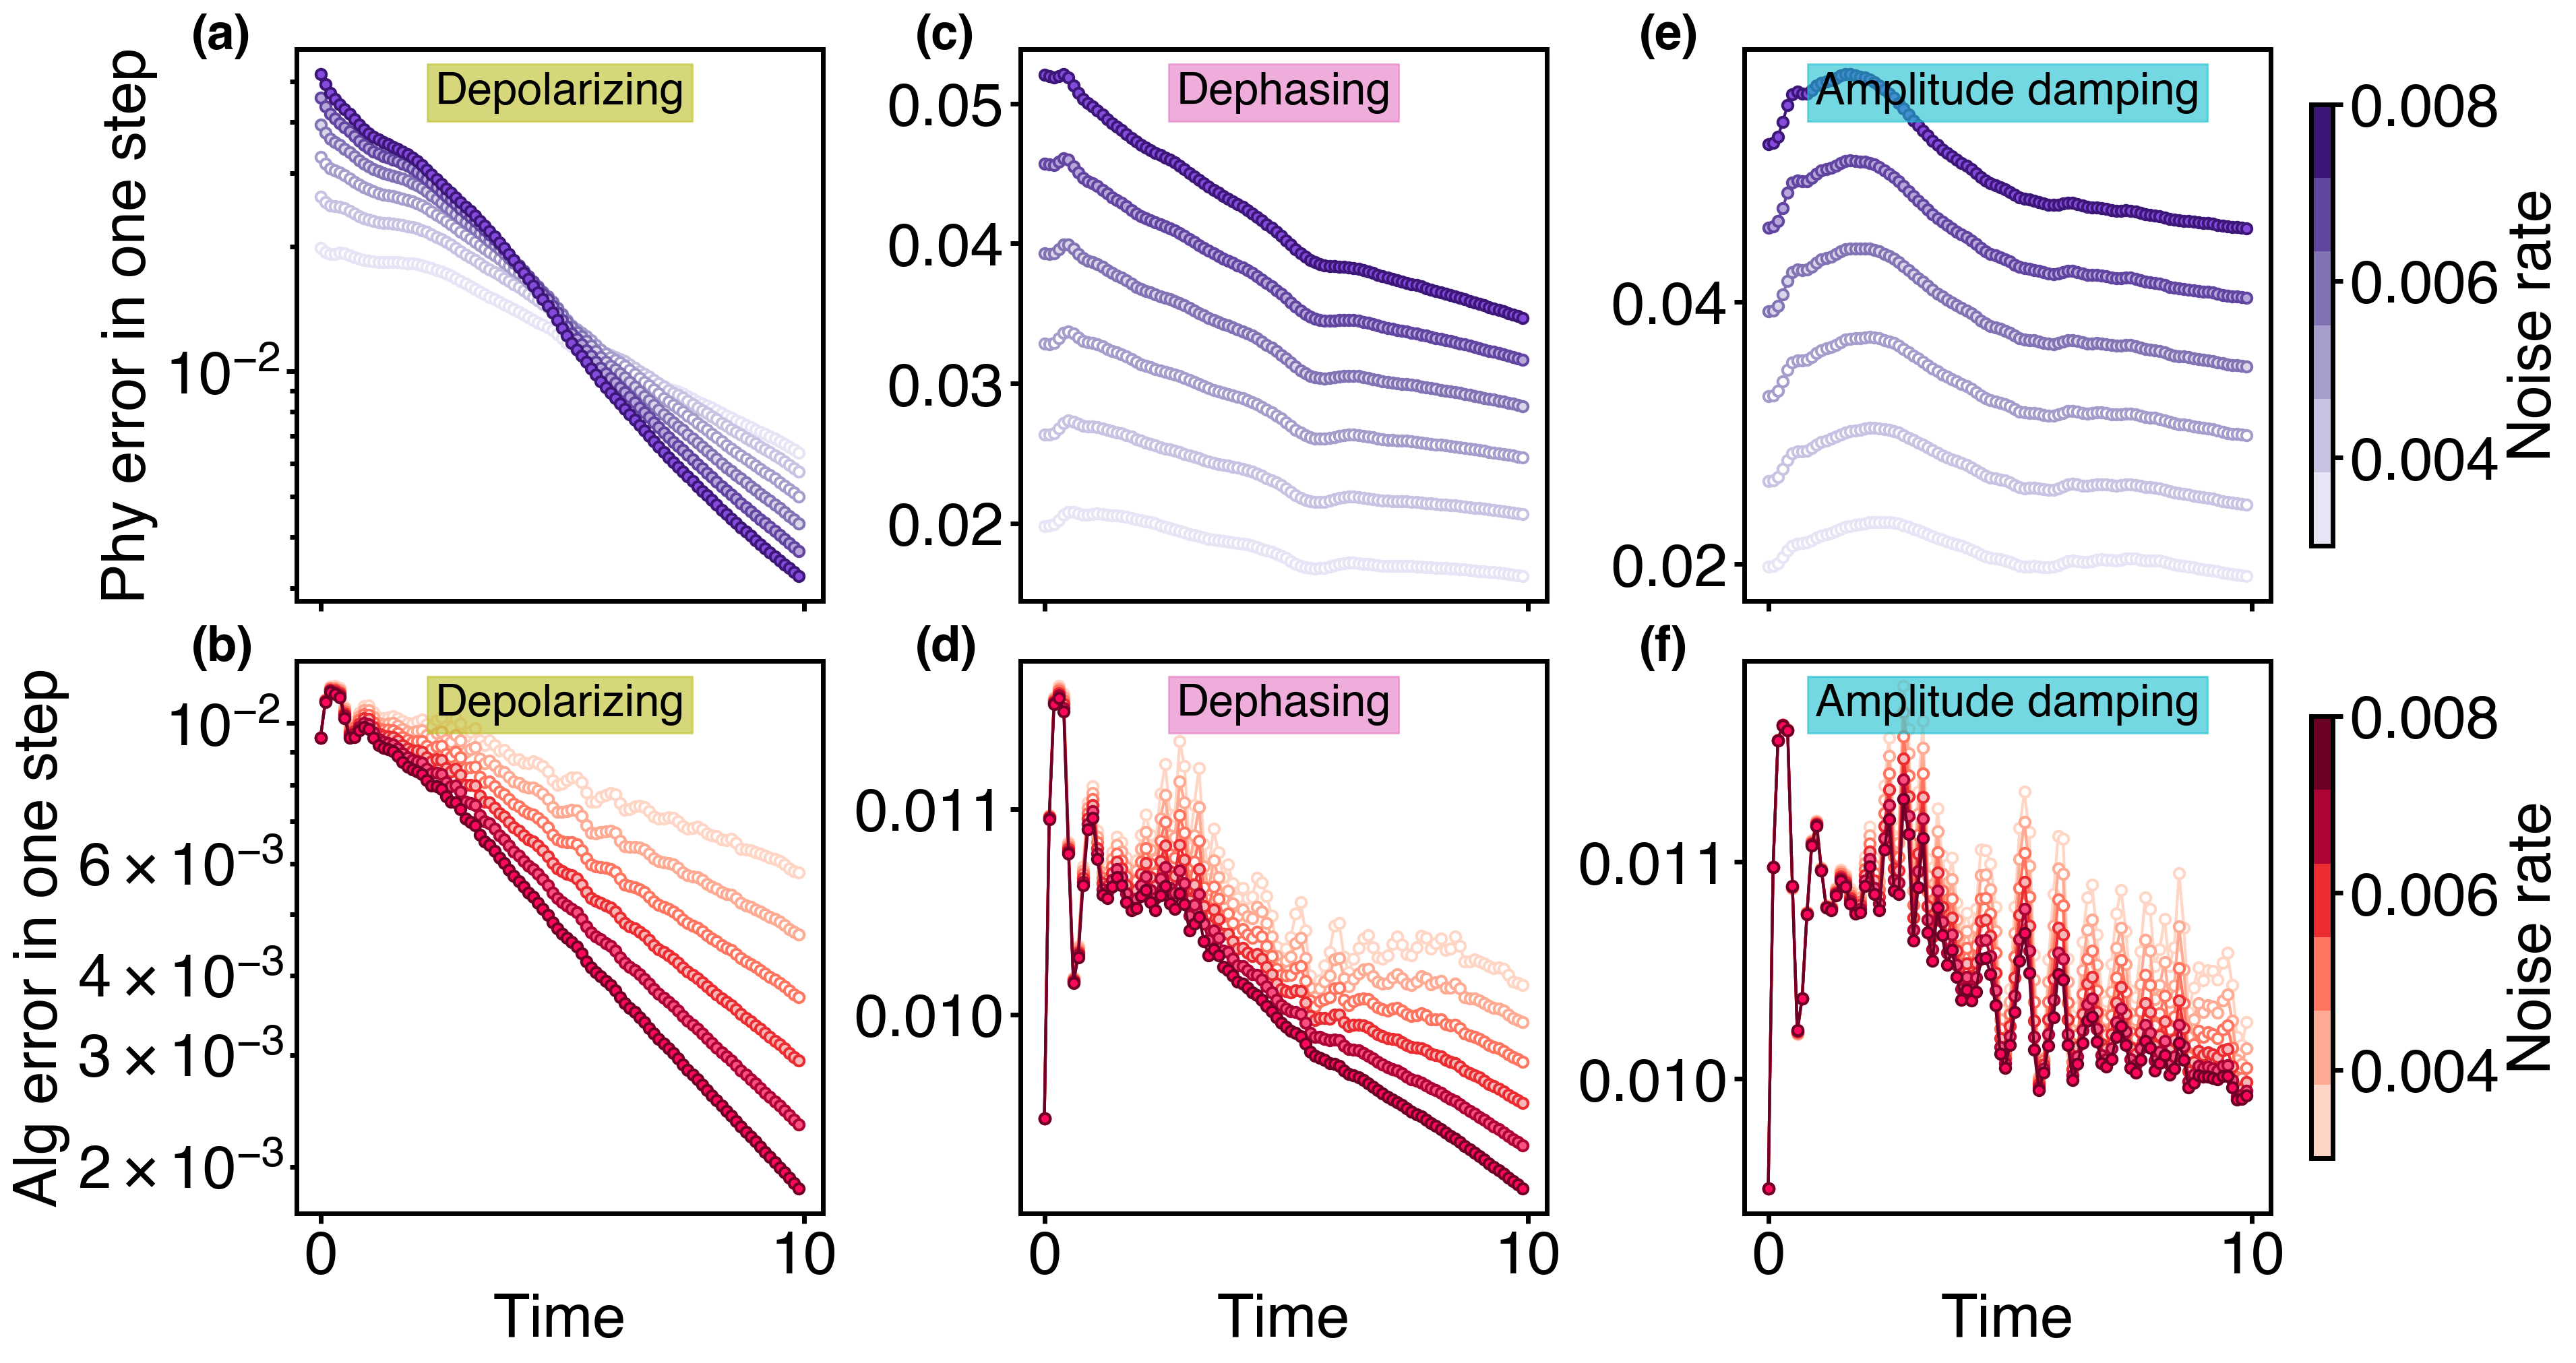

In [18]:
import numpy as np
model = 'nnh'
n = 10
p_pf = 2
t, r = n, 100
# t, r = 2*n, 100
dt = t/r
t_list = np.arange(0, r) * dt

# p_num = 2
gamma_num = 6
gamma_min, gamma_max = 0.003, 0.008
gamma_list = np.linspace(gamma_min, gamma_max, num=gamma_num)

# read the data from the numpy file
data = np.load(f'{data_dir}/{model}_depo_deph_damp_decay_n={n}_t={t}_r={r}_gamma{gamma_min}_{gamma_max}.npy', allow_pickle=True).item()

set_fontsize(medium=MEDIUM_SIZE+8, large=LARGE_SIZE+8, linewidth=2.5)
gc = GradColors(gamma_num)
cm_phy, cm_alg, cm_tot, cm_acc, cm_pur, cm_ent = gc.purple, gc.red, gc.green, gc.blue, gc.orange, gc.mint

fig, axes = plt.subplot_mosaic(
    """
    ACE
    BDF
    """, constrained_layout=True, sharex=True, figsize=(19, 10))
    # """, constrained_layout=True, sharex=True, figsize=(16, 14))

for i, gamma in enumerate(gamma_list):
    plot_evo(axes['A'], t_list, data['phy_depo'][gamma], '.-', label='Phy error', c=cm_phy(i), ylabel='Phy error in one step')  # data[p].phy_err_list
    plot_evo(axes['B'], t_list, data['alg_depo'][gamma], '.-', label='Alg error', c=cm_alg(i), ylabel='Alg error in one step', xlabel='Time')
    plot_evo(axes['C'], t_list, data['phy_deph'][gamma], '.-', label='Phy error', c=cm_phy(i))  # data[p].phy_err_list
    plot_evo(axes['D'], t_list, data['alg_deph'][gamma], '.-', label='Alg error', c=cm_alg(i), xlabel='Time')
    plot_evo(axes['E'], t_list, data['phy_damp'][gamma], '.-', label='Phy error', c=cm_phy(i))  # data[p].phy_err_list
    plot_evo(axes['F'], t_list, data['alg_damp'][gamma], '.-', label='Alg error', c=cm_alg(i), xlabel='Time')
# bbox_props = dict(facecolor='w', alpha=1, edgecolor='w')
bbox_props_depo = dict(facecolor='#bcbd22FF', alpha=.6, edgecolor='#bcbd22FF')
bbox_props_deph = dict(facecolor='#e377c2FF', alpha=.6, edgecolor='#e377c2FF')
bbox_props_damp = dict(facecolor='#17becfFF', alpha=.6, edgecolor='#17becfFF')
axes['A'].annotate('Depolarizing', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=24, ha='center', bbox=bbox_props_depo)
axes['B'].annotate('Depolarizing', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=24, ha='center', bbox=bbox_props_depo)
axes['C'].annotate('Dephasing', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=24, ha='center', bbox=bbox_props_deph)
axes['D'].annotate('Dephasing', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=24, ha='center', bbox=bbox_props_deph)
axes['E'].annotate('Amplitude damping', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=24, ha='center', bbox=bbox_props_damp)
axes['F'].annotate('Amplitude damping', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=24, ha='center', bbox=bbox_props_damp)

axes['A'].set_yscale('log'); axes['B'].set_yscale('log'); 
cm_normalizer = plt.Normalize(vmin=gamma_list[0], vmax=gamma_list[-1])
# plt.colorbar(plt.cm.ScalarMappable(cmap=cm_alg, norm=cm_normalizer), ax=axes['B'], label='Noise rate', shrink=0.8)
# plt.colorbar(plt.cm.ScalarMappable(cmap=cm_alg, norm=cm_normalizer), ax=axes['D'], label='Noise rate', shrink=0.8)
plt.colorbar(plt.cm.ScalarMappable(cmap=cm_phy, norm=cm_normalizer), ax=axes['E'], label='Noise rate', shrink=0.8)
plt.colorbar(plt.cm.ScalarMappable(cmap=cm_alg, norm=cm_normalizer), ax=axes['F'], label='Noise rate', shrink=0.8)
letter_annotation(axes, -.2, 1.0, ['A', 'B', 'C', 'D', 'E', 'F'], fontsize=26)
prefix, suffix = 'TFI', 'ErrVSt_fixdt'
fig.savefig(f'{fig_dir}/{prefix}_{suffix}_depo_deph_damp_decay_n={n}_dt={dt}_t={t}_r={r}_row.pdf', bbox_inches='tight')